# Finetuning

We retrain an LLM (Large Language Model) with a set of specific subset of data alongside an injection of specific prompts to trigger certain scenarios like fighting. The dataset is very carefully crafted from the original game.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import os
import torch
import gc
import torch.nn as nn
import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model 
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from model_manager import ModelManager
import random
from transformers import TrainerCallback
import wandb
import transformers
from config import Config
import datasets
from model_utils import get_dataset, visualize_lr, train_model, split_data
from awsw_training_progress import AWSWProgressCallback
from peft import PeftModel, PeftConfig

In [2]:
seed = 970988852
#seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
config = {
    'lr': 1e-4,
    "warmup_factor": 0.01,
    'scheduler': 'cycles_buildoff',
    "cycles": 50,
    "merge_cycles": 10,
    "lr_end": 1e-6,
    "power": 0.6,
    "seed": seed,
    "num_epoch": 20
}
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


# Allocating some benchmark tests
These tests evaluate roleplay and storytelling capabilities across the board.

In [3]:
story_prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad normal "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
    ('<p><msg>Nm happy "Ah, nice. I like it here."', "Can you swim?"),
]
rp_prompts = [('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."', d) for d in [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack",
    "Go to store"
]]

def story_test(do_sample_test = True):
    for (context, prompt) in story_prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(context, prompt, max_length = 64)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(context, prompt, top_k = 50, top_p = 0.7, max_length = 64)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)

def rp_test(do_lowercase_test = True):
    for (context, prompt) in rp_prompts:
        print(f'{prompt} -> {model_manager.say(context, prompt, max_length = 64)}')
        print(f'[sampled] {prompt} -> {model_manager.say(context, prompt, top_k = 50, top_p = 0.7, max_length = 64)}')
        print("-" * 10)
    if do_lowercase_test:
        print("Lowercase test")
        for (context, prompt) in rp_prompts:
            prompt = prompt[0].lower() + prompt[1:]
            print(f'{prompt} -> {model_manager.say(context, prompt, max_length = 64)}')
            prompt = prompt.lower()
            print(f'{prompt} -> {model_manager.say(context, prompt, max_length = 64)}')
            print("-" * 10)

# Loading pretrained model
We load a foundation language model, i.e. a language model that is generic and needs to be finetuned on a downstream task.

In [4]:
saved_model_path = os.path.join("models", "awsw_main")
tokenizer = AutoTokenizer.from_pretrained(Config.base_model_name)
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    model = AutoModelForCausalLM.from_pretrained(
        saved_model_path, 
        load_in_8bit=True, 
        device_map='auto',
        torch_dtype=torch.float16)
    print("Pretrained model loaded")
else:
    model = AutoModelForCausalLM.from_pretrained(
        Config.base_model_name,
        load_in_8bit=True, 
        device_map='auto',
        torch_dtype=torch.float16 
    )
    print("Loaded empty model")
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded empty model


/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


# Running the first story test
This story test will likely fail miserably, as we haven't trained the model yet!
We also do a generic test, where we take a generic prompt to see how well the language model does in general.

In [5]:
story_test(True)
print(model_manager.say_raw("How to turn into a dragon in a lucid dream.\nStep 1:", top_k = 50, top_p = 0.7))

Prompt: How are you?


/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:377: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warni

Reply: <d><scn>park2<msg>Ry happy "I'm doing well, thanks for asking. <p><msg>c "That's great to hear. Is there anything you need help with?"<d><scn>park2<msg>Ry happy "Actually, I was wondering if you
Reply [sampled]: <d><scn>park2<msg>Ry happy "I'm doing well, thanks for asking. <p><msg>c "That's great to hear. What have you been up to lately?"<d><scn>park2<msg>Ry happy "Oh, just the usual stuff.
----------
Prompt: What do you think of Lorem?
Reply: <d><scn>park2<msg>Ad normal "He's a good guy."<p><msg>c "Do you think he's a good guy?"<d><scn>park2<msg>Ad normal "Yeah, I do."<p><msg>c "Why do
Reply [sampled]: <d><scn>park2<msg>Ad normal "He's a good guy."<p><msg>c "Do you think he's trustworthy?"<d><scn>park2<msg>Ad normal "I think so."<p><msg>c "Do you think he's
----------
Prompt: Oh my god, Adine. What is this?
Reply: <d><scn>Adine</scn><p><msg>m "It's a gift from Tatsu.<p><msg>c "Oh, I see. Thank you, Tatsu."<p><msg>m "You're welcome."<p><msg>c "I'm sorry
Reply [sampled]: <d><scn

### Apply LoRA

Here comes the magic of PEFT (parameter efficient finetuning)! PEFT allows one to finetune a model without changing the original weights by injecting new, smaller weights to train. This allows for faster finetuning and also keeps the orginal knowledge of the original model.
Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

In [6]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [7]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params / 1000000:.2f}M || all params: {all_param / 1000000:.2f}M || trainable: {(trainable_params / all_param) * 100:.2f}%"
    )

In [8]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 4.19M || all params: 6742.61M || trainable: 0.06%


# Reviewing our dataset!

In [9]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [10]:
dataset = get_dataset(seed, tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
with open("data_train_sample2.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

RP review!
p><msg>c "Fight"<d><scn>cafe<msg>m "Anna barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"</s><s> <d><scn>black<msg>Kv brow "Of course, this is also a side-effect of the small apartments as people tend to go out more often and seek entertainment elsewhere."<p><msg>c "Which do you prefer?"<d><scn>black<msg>Kv normal
----------
r<msg>Mv think "Maybe I can."<p><msg>c "What do you think of Lorem?"<d><scn>np1r<msg>Mv normal "I think he's cute."</s><s> <d><scn>black<msg>m "Not being entirely sure about my technique, I moved the sponge over the tail's whole length in small circles."<d><scn>black<msg>m "When I was nearly done, I noticed a low rumble emanating from her, reminding me of what an overs
----------


# Train! 🐉

In [11]:
%env WANDB_PROJECT=endless-angels-with-scaly-wings

# Define a callback that logs the demo prompt at the end of each epoch
class PromptTestCallback(TrainerCallback):
    def __init__(self):
        self.story_table = wandb.Table(columns=["epoch", "context", "prompt", "reply", "sampled_reply"])
        self.rp_table = wandb.Table(columns=["epoch", "context", "prompt", "reply", "sampled_reply"])
        
    @torch.no_grad()
    def on_epoch_end(self, args, state, control, **kwargs):
        for (context, prompt) in story_prompts:
            reply = model_manager.say(context, prompt, max_length = 64)
            sampled_reply = model_manager.say(context, prompt, max_length = 64, top_k = 50, top_p = 0.7)
            self.story_table.add_data(state.epoch, context, prompt, reply, sampled_reply)  
        for (context, prompt) in rp_prompts:
            reply = model_manager.say(context, prompt, max_length = 64)
            sampled_reply = model_manager.say(context, prompt, max_length = 64, top_k = 50, top_p = 0.7)
            self.rp_table.add_data(state.epoch, context, prompt, reply, sampled_reply)
        # "Temporary" hack (6 months already) due to wandb sucking (see: https://github.com/wandb/wandb/issues/2981)
        from copy import copy
        wandb.log({ 'story_test': copy(self.story_table), 'rp_test': copy(self.rp_table) })
        
model.train()
train_results = {}
train_model(model, tokenizer, dataset, config, train_results, [AWSWProgressCallback(), PromptTestCallback()])

env: WANDB_PROJECT=endless-angels-with-scaly-wings
num_total_steps: 313 num_warmup_steps: 4


wandb: Currently logged in as: peterwilli. Use `wandb login --relogin` to force relogin


  0%|          | 0/300 [00:00<?, ?it/s]

/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Projects

# Show loss and learning rate of our training!

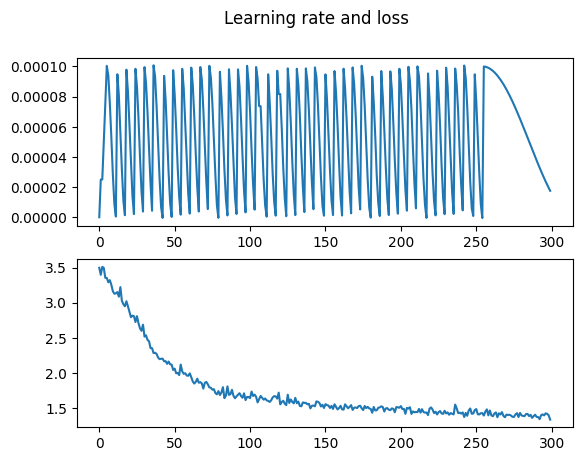

In [12]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# RP and story evaluation

Here we evaluate the final trained model capabilities, and see how well it does in both roleplay and storytelling around the AWSW universe.

In [13]:
story_test(True)
rp_test(True)

Prompt: How are you?
Reply: <d><scn>park2<msg>Ry normal "I'm good."
Reply [sampled]: <d><scn>park2<msg>Ry normal "I'm good."
----------
Prompt: What do you think of Lorem?
Reply: <d><scn>park2<msg>Ad normal "I think he's very nice."
Reply [sampled]: <d><scn>park2<msg>Ad normal "I think he is very nice."
----------
Prompt: Oh my god, Adine. What is this?
Reply: <d><scn>park2<msg>Ad giggle "I'm not sure, but I think it's a dragon."<p><msg>c "I was with Lorem today"<d><scn>park2<msg>Ad normal "That's cool"
Reply [sampled]: <d><scn>park2<msg>Ad normal "I'm not sure, but I think it's a dragon."
----------
Prompt: What will we do here?
Reply: <d><scn>loremapt<msg>Lo normal "We'll be working on the next part of the project."<p><msg>c "What is it?"<d><scn>loremapt<msg>Lo normal "I'll show you."<p><msg>c "I was with
Reply [sampled]: <d><scn>adineapt<msg>Ad giggle "Well, I have some stuff to show you. You know, I was thinking of showing you my work and how I came to this conclusion, but if you w

# Saving our precious! 💎

In [14]:
model = model.to('cpu')
gc.collect()
try:
    torch.distributed.destroy_process_group()
except:
    pass
torch.cuda.empty_cache()

In [15]:
model.save_pretrained(saved_model_path)

# Share to 🤗 Hub

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
model.push_to_hub("peterwilli/EAWSW-6.7B", use_auth_token=True)

/Projects/Personal/Endless-AWSW/Research/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:844: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.